#### Load required modules

In [8]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

sim_folder = 'dos/SHWFS_ES'

In [116]:
# Reload DOS library
import importlib
importlib.reload(dos)


<module 'dos' from '/Users/rromano/Workspace/SIMCEO/dos/__init__.py'>

In [212]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

#### Compute reconstructor from interacion matrix

In [193]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

# Load calibration data 
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM_ES.npz', allow_pickle=True)
# Compute SH-WFS consolidated interaction matrix
Dsh = dos.tools.get_SHWFS_D(dt['calibdt'][()]['D'], includeM1S7Rz_col=True)
n_bm = (Dsh.shape[1] - 82)//7
if((Dsh.shape[1] - 82)%7):
    print('Noninteger result in n_bm computation!')

# Merge SH-WFS and Edge sensor interaction matrix
alphaBM, alphaEs= 1.0, 1.0 # 1.0/40, 10
Dm = dos.tools.merge_SH_ES_D(Dsh, dt['calibdt'][()]['De'], alphaBM=alphaBM, alphaEs=alphaEs)
# Piston nduced by M2 calibration matrix
Pm2 = dt['calibdt'][()]['P2']
P = np.hstack( [np.zeros((Pm2.shape[0],41)), Pm2[:,:-1], np.zeros((Pm2.shape[0],7*n_bm))])
M = dos.tools.build_RLS_RecM(Dsh, dt['calibdt'][()]['De'], P, rhoP=0*1.0e1, n_r=12)
#M = dos.tools.build_RLS_RecM(Dsh, De=np.empty([0,0]), P=P, rhoP=0*1.0e1, n_r=18)


# M = dos.tools.build_TSVD_RecM(Dsh,  n_r=12)

# Rescale reconstructor based on interaction matrix merge weights
# BMin_weight_vec = np.ones(M.shape[0])
# n_bm, n_es = 46, dt['calibdt'][()]['De'].shape[0]
# BMin_weight_vec[-7*n_bm:] = alphaBM
# s_weight_vec = np.ones(M.shape[1])
# s_weight_vec[-n_es:] = alphaEs
# M = np.dot(np.diag(BMin_weight_vec), M.dot(np.diag(s_weight_vec)))

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):    
    Msimceo = dos.tools.gen_recM_4_SIMCEO(M, dt['calibdt'][()]['wfsMask'])
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    # dos.tools.linear_estimator_2_dos(np.eye(Msimceo.shape[0]),sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')
    print('SIMCEO recosntructor matrix dimensions:',Msimceo.shape)

Consolidated WFS-SH Interaction matrix is 7360 x 404
Regularization term coefficients:
 [4.90278441e-04 1.56631566e-03 1.61749505e-03 1.68357510e-03
 2.34016611e-02 2.35955950e-02 6.24148336e-02 6.27276720e-02
 8.19375631e-01 8.64578411e-01 9.25631185e-01 1.00000000e+00]
SH-WFS reconstructor matrix pickle file is updated!
SIMCEO recosntructor matrix dimensions: (406, 13872)


(0, 0)

In [4]:
M.shape, dt['calibdt'][()]['De'].shape

((406, 7408), (48, 36))

#### Set initial M1/M2 states and generate respective yaml files

In [204]:
# Python code to set simulation states...
from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

# * * * Flag to control if simulation initial state must be updated * * *
updateX0 = True

asec2rad = 4.84814e-6
n_bm = 46
k_states = 1 # 0.5
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateX0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*(2*np.random.rand(6)-1),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M1_Rz = k_states*40*asec2rad*(2*np.random.rand(7,1)-1)
    x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)

    m1_x0_dt = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateX0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M2_Tz = k_states*170.0e-6*(2*np.random.rand(7,1)-1)
    x0_M2_Rxy = k_states*3.0*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M2_Rz = k_states*330*asec2rad*(2*np.random.rand(7,1)-1)

    m2_x0_dt = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

#### Instantiate DOS

In [205]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SHWFS_ES/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: M1_ES
INFO:M1_ES:No inputs!
INFO:M1_ES:New output: deltas
INFO:M1_ES:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New input: edge sensors
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged 

SIMCEO server received: Acknowledging connection from SIMCEO client!


INFO:DOS:Simulation setup for a duration of 50s @ 1Hz (50 steps)!


In [206]:
# Start simulation
sim.start()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:M1_ES:EdgeSensors
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:M1_ES:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:M1_ES:EdgeSensors deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 31.167014122009277


In [ ]:
sim.push()

In [ ]:
sim.init()

In [ ]:
sim.terminate()

#### Simulation results

In [ ]:
sim.logs.entries.keys(), sim.logs

Final values:
 WFE: [2781.42101706] 
 [3.30267924 3.17948579 3.61602437 4.93933872 4.04787803 3.54475782
 6.29098151] 
PSSn: [0.99988399] 
sum of abs seg piston: 24.978066448966274 
 [-4.297533   -7.26597409 -2.76821083 -2.02505271  2.53662483 -2.02680803
 -4.05786295]


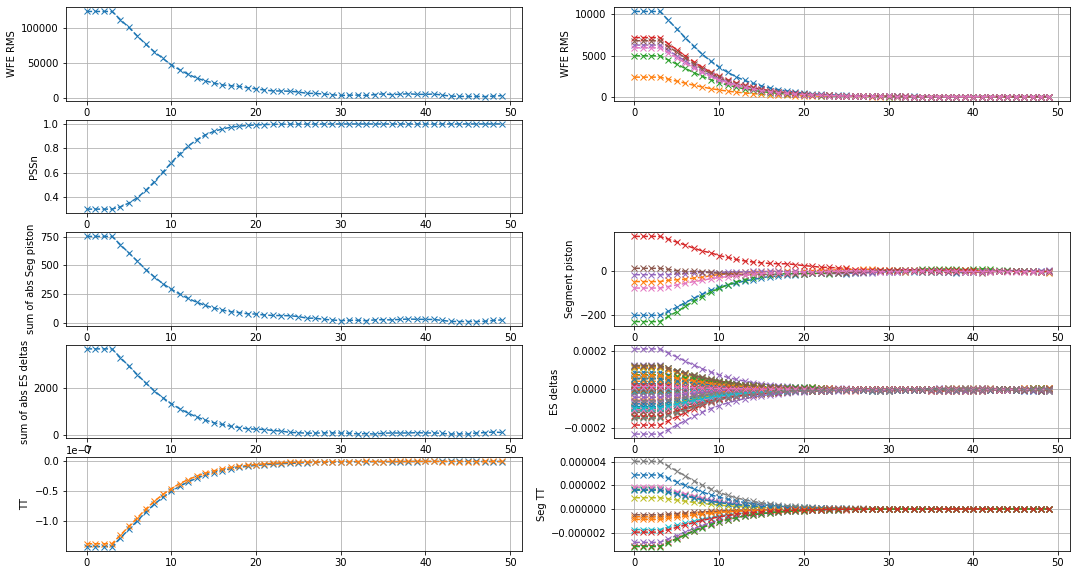

In [196]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

Final values:
 WFE: [2122.37273445] 
 [3.36650197 3.30133809 3.37983086 4.83806106 3.84681886 3.43508422
 6.20278495] 
PSSn: [0.99984877] 
sum of abs seg piston: 19.705180420714896 
 [-3.33978278 -2.40939539  1.25861482 -1.47592311 -1.07247797 -5.52008532
 -4.62890102]


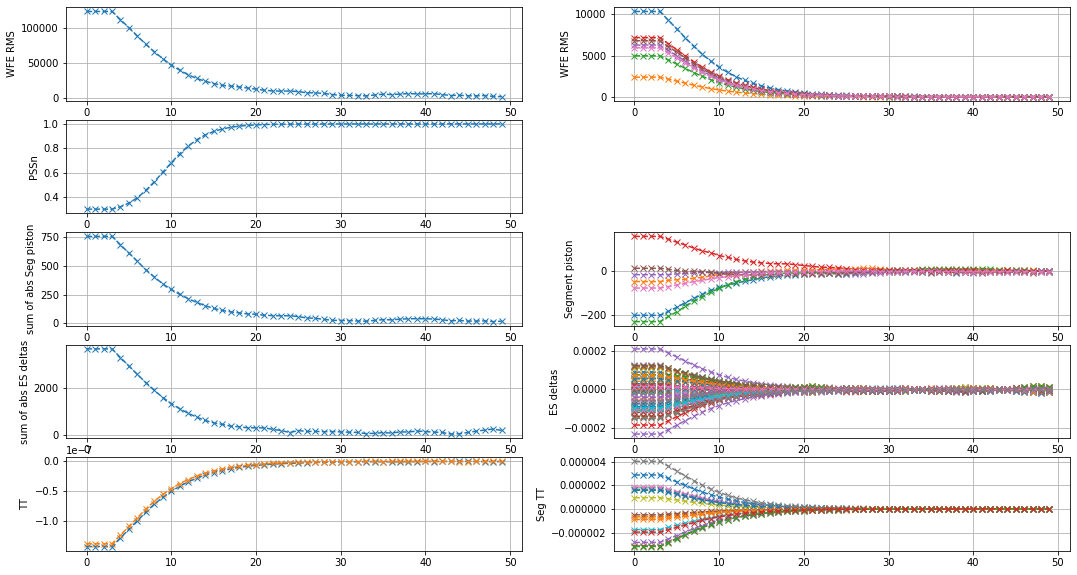

In [191]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

Final values:
 WFE: [150058.50582384] 
 [5.24759116e+01 7.84726595e+00 9.59487600e+00 1.16197878e+01
 1.95605097e+01 8.48993551e+01 3.57763311e+04] 
PSSn: [0.86371486] 
sum of abs seg piston: 455.0227171904453 
 [-6.76405932e-01  6.81240863e-01  6.39086750e-01  1.01902387e-01
  2.07820307e-01  7.26726375e+00 -4.45448997e+02]


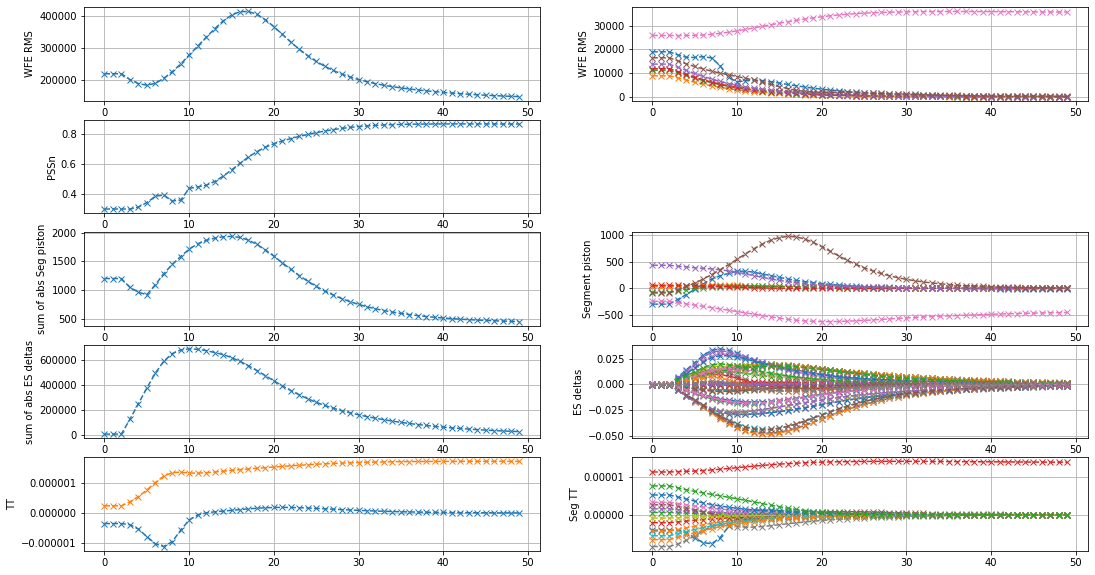

In [207]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

#### Control effort

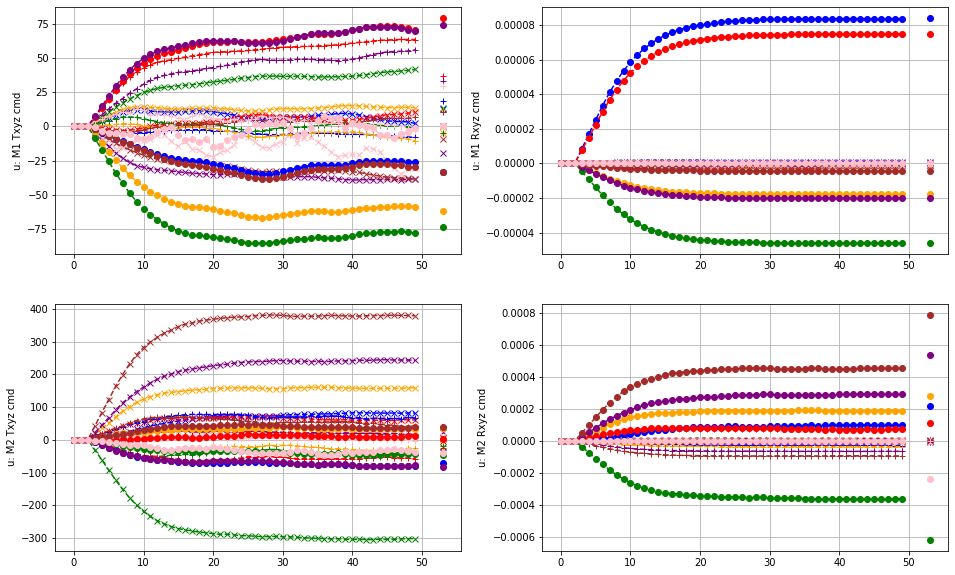

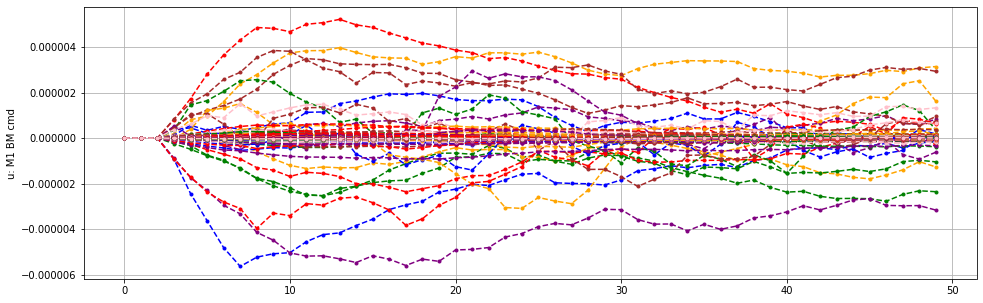

In [183]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Mismatch steady-state

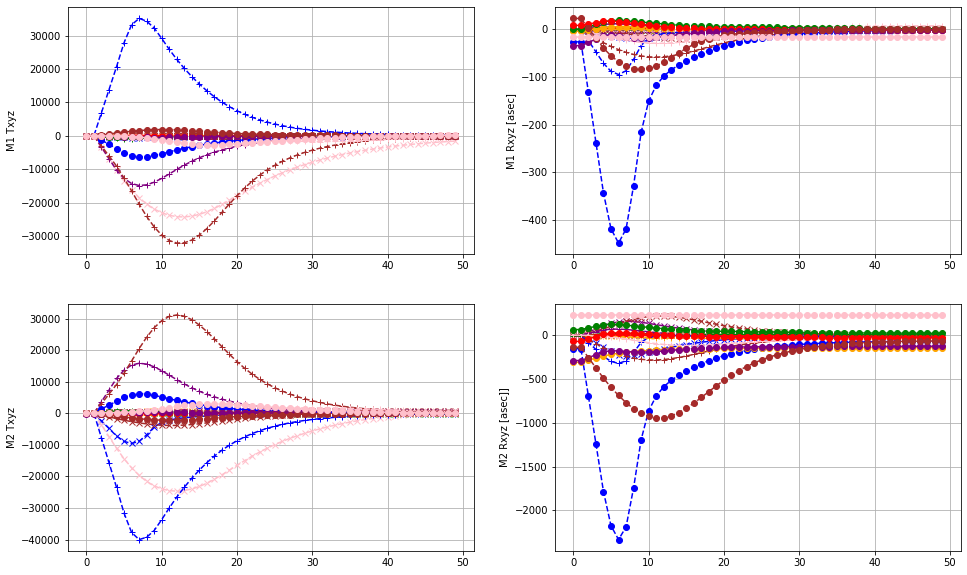

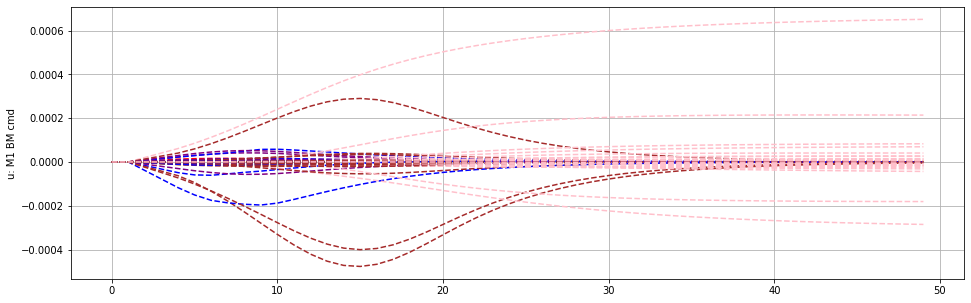

In [213]:
U = sim.logs.entries['AcO_controller']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Reconstructed states

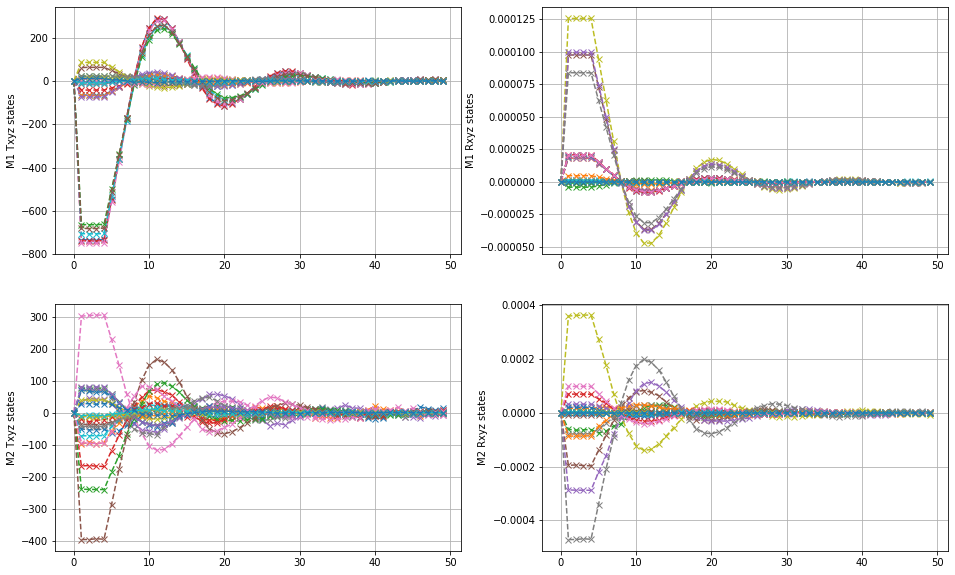

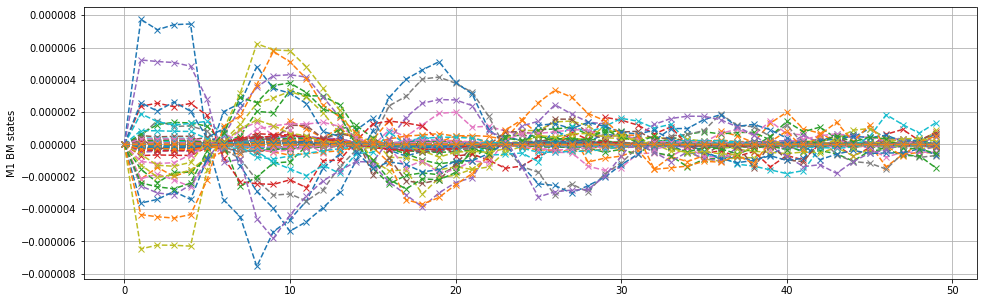

In [141]:
ptools.plot_states(sim.logs.entries['ReconstructorM']['x_hat'].timeSeries, n_bm)

### Baseline estimator results

Final values:
 WFE: [1478.09726059] 
 [16.06897548  4.78845052 13.33889532 12.4888242   8.75857697 15.27463134
  7.43284279] 
PSSn: [0.99988169] 
sum of abs seg piston: 12.899576411484759 
 [ 2.55588748  0.81347997  0.1132938   1.85297915  3.48320168  3.62014885
 -0.46058548]


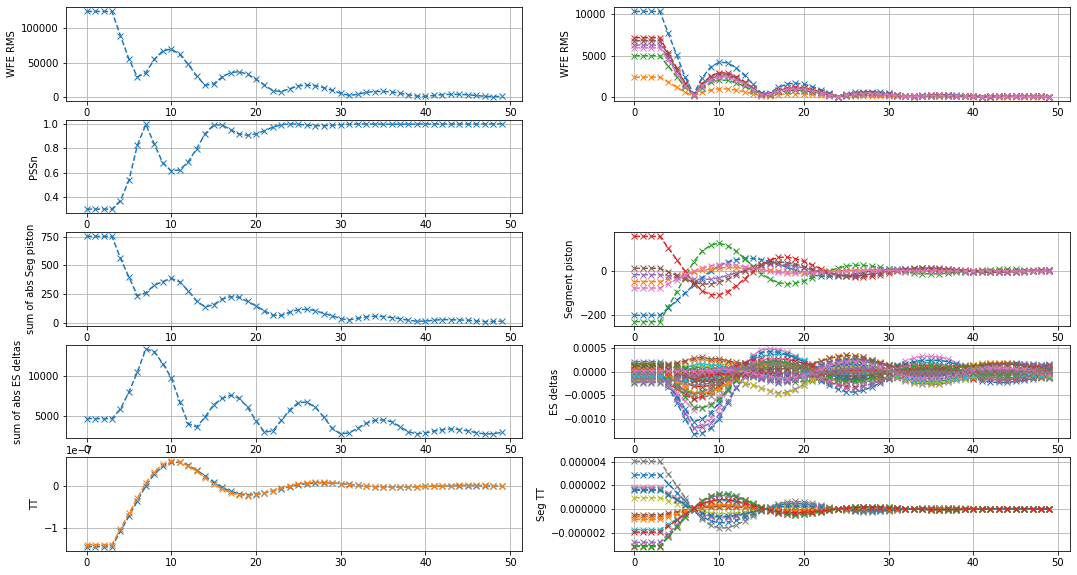

In [45]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

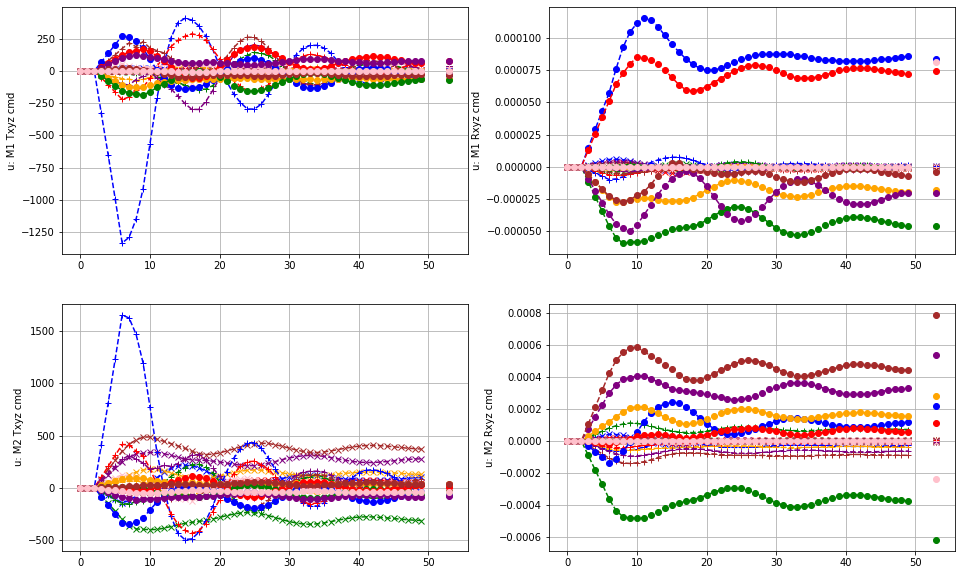

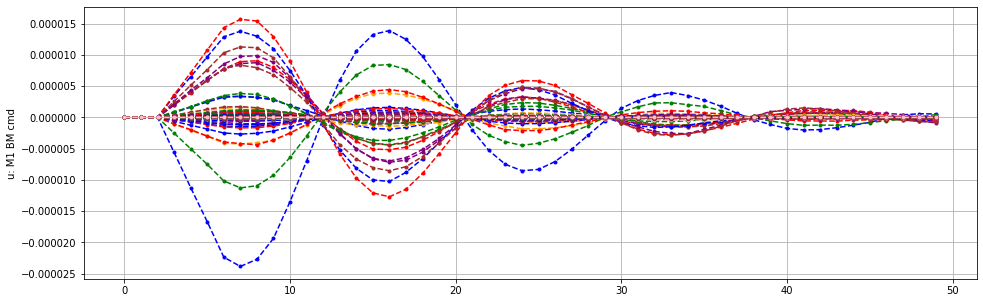

In [46]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Mismatch steady-state

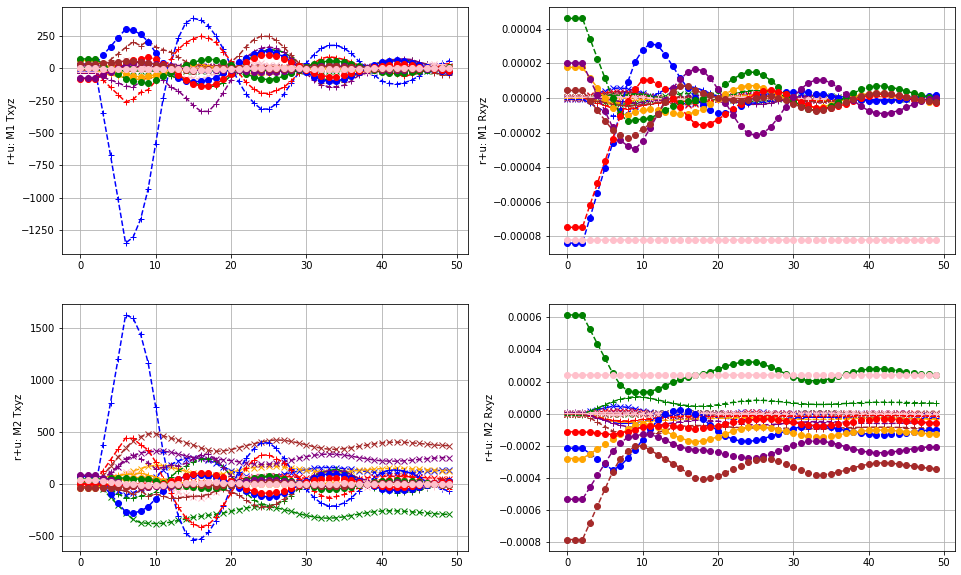

Text(0, 0.5, 'r+u: M1 BM')

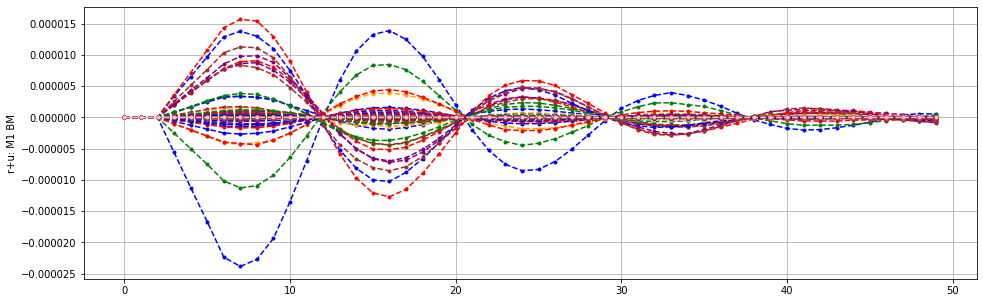

In [47]:
U = sim.logs.entries['AcO_controller']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Reconstructed states

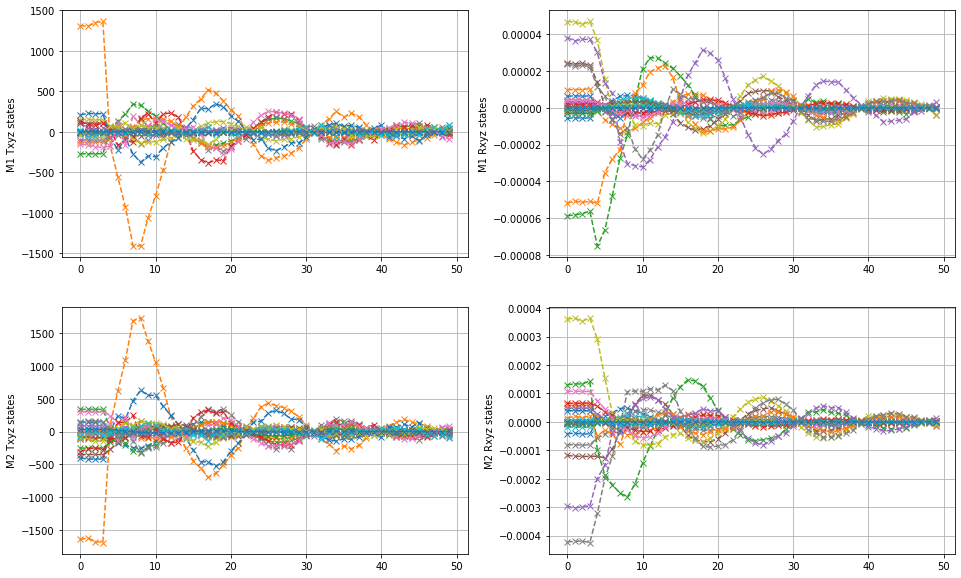

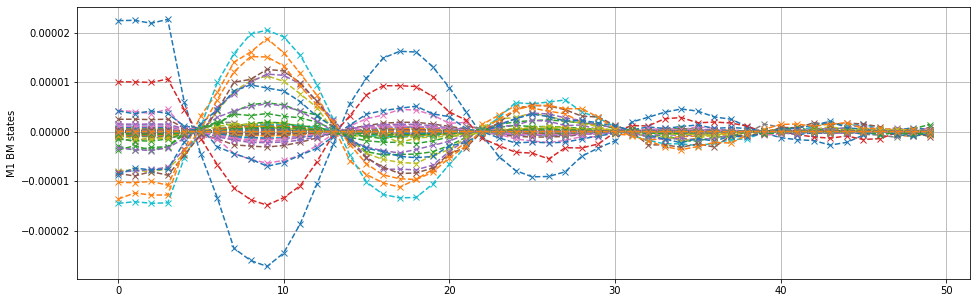

In [48]:
ptools.plot_states(sim.logs.entries['wfs48']['M12_RBM'].timeSeries, n_bm)